# Spotify Genre Classifier

## Setup

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk, path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy import stats
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

In [2]:
# load data

# get all filenames from the directory data
f = []
for (dirpath, dirnames, filenames) in walk("data"):
    f.extend(filenames)
    break

# load data from all files from the directory data
frames = []
for file in f:
    data = pd.read_json(path.join("data", file))
    frames.append(data)

# concat all data into one dataframe
raw_data = pd.concat(frames, ignore_index=True)

## Visualization

### Clean Dataset

In [249]:
raw_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0.1930,0.11600,9,-25.718,1,0.0608,0.986,0.91800,0.5050,0.0836,143.301,audio_features,6pV1dGidc6DvzjKhbMqgDa,spotify:track:6pV1dGidc6DvzjKhbMqgDa,https://api.spotify.com/v1/tracks/6pV1dGidc6Dv...,https://api.spotify.com/v1/audio-analysis/6pV1...,242467,3,classic
1,0.3210,0.00611,4,-38.341,0,0.0362,0.995,0.90800,0.0900,0.0693,104.311,audio_features,1YcABWwgkfrOSw8VMgDWZU,spotify:track:1YcABWwgkfrOSw8VMgDWZU,https://api.spotify.com/v1/tracks/1YcABWwgkfrO...,https://api.spotify.com/v1/audio-analysis/1YcA...,205493,4,classic
2,0.4480,0.00520,4,-36.512,1,0.0564,0.995,0.88000,0.0698,0.0398,62.171,audio_features,1juisCcrVdwoLbDWyVvNrX,spotify:track:1juisCcrVdwoLbDWyVvNrX,https://api.spotify.com/v1/tracks/1juisCcrVdwo...,https://api.spotify.com/v1/audio-analysis/1jui...,369027,4,classic
3,0.4250,0.03630,1,-21.629,0,0.0686,0.991,0.00109,0.2500,0.7450,78.991,audio_features,1AKdBq4wtJKU9DhQpekvtc,spotify:track:1AKdBq4wtJKU9DhQpekvtc,https://api.spotify.com/v1/tracks/1AKdBq4wtJKU...,https://api.spotify.com/v1/audio-analysis/1AKd...,143777,4,classic
4,0.0748,0.04420,0,-19.183,1,0.0426,0.957,0.94000,0.1160,0.0369,79.092,audio_features,5X5x6oRSCHtHEz28ncMVd5,spotify:track:5X5x6oRSCHtHEz28ncMVd5,https://api.spotify.com/v1/tracks/5X5x6oRSCHtH...,https://api.spotify.com/v1/audio-analysis/5X5x...,348907,4,classic


In [250]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre'],
      dtype='object')

In [3]:
# now drop some features which have no importance for the ML task
raw_data.drop(["uri", "id", "track_href", "analysis_url", "type"], axis=1, inplace=True)

In [4]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre'],
      dtype='object')

In [5]:
raw_data.shape

(1515, 14)

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1515 non-null   float64
 1   energy            1515 non-null   float64
 2   key               1515 non-null   int64  
 3   loudness          1515 non-null   float64
 4   mode              1515 non-null   int64  
 5   speechiness       1515 non-null   float64
 6   acousticness      1515 non-null   float64
 7   instrumentalness  1515 non-null   float64
 8   liveness          1515 non-null   float64
 9   valence           1515 non-null   float64
 10  tempo             1515 non-null   float64
 11  duration_ms       1515 non-null   int64  
 12  time_signature    1515 non-null   int64  
 13  genre             1515 non-null   object 
dtypes: float64(9), int64(4), object(1)
memory usage: 165.8+ KB


In [4]:
# remove samples with key == -1
befor = len(raw_data)
raw_data = raw_data[raw_data.key != -1]
print(f"Removed samples: {befor - len(raw_data)}")

Removed samples: 0


In [6]:
# remove samples where time_signature is out of bounds [3:7]
befor = len(raw_data)
raw_data = raw_data[(raw_data.time_signature >= 3) & (raw_data.time_signature <= 7)]
print(f"Removed samples: {befor - len(raw_data)}")

Removed samples: 0


In [9]:
raw_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1.496000e+03,1496.000000
mean,0.518864,0.576181,5.324866,-10.743261,0.554813,0.101637,0.359781,0.244451,0.181888,0.405590,118.611152,2.726669e+05,3.922460
std,0.209155,0.328465,3.553143,8.596414,0.497153,0.103556,0.403647,0.369033,0.143416,0.259752,31.233030,1.245252e+05,0.338208
min,0.061800,0.002090,0.000000,-44.526000,0.000000,0.025000,0.000002,0.000000,0.023400,0.027100,47.362000,8.426700e+04,3.000000
25%,0.375000,0.271750,2.000000,-14.000250,0.000000,0.040475,0.010200,0.000000,0.092575,0.167000,93.895250,1.959170e+05,4.000000
50%,0.516500,0.678000,5.000000,-7.225500,1.000000,0.052400,0.108500,0.000865,0.122000,0.387000,116.799500,2.378620e+05,4.000000
75%,0.667000,0.864000,8.000000,-4.709500,1.000000,0.112000,0.838250,0.618250,0.234250,0.616000,145.010500,3.040568e+05,4.000000
max,0.964000,0.998000,11.000000,-0.100000,1.000000,0.944000,0.996000,0.981000,0.972000,0.958000,206.247000,1.252322e+06,5.000000


In [7]:
# if you want to compare statistic informations from specific features you can use: data.groupby('genre').describe()["feature1", "feature2", ...]
raw_data.groupby(raw_data["genre"]).describe()["energy"]

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
classic,280.0,0.075755,0.081465,0.00209,0.01550,0.0461,0.11600,0.475
edm,303.0,0.871954,0.088732,0.56400,0.82600,0.8840,0.94000,0.998
hiphop,325.0,0.695074,0.134331,0.30800,0.60100,0.7010,0.80100,0.952
jazz,292.0,0.352654,0.186844,0.00756,0.22175,0.3440,0.50075,0.783
rock,296.0,0.836757,0.132142,0.28000,0.77900,0.8770,0.93225,0.998


### Plots

In [ ]:
sorted_list = raw_data["genre"].value_counts().sort_values()
labels = sorted_list.index.tolist()
values = sorted_list.tolist()

plt.bar(labels, values)
plt.title(f"No. of samples {raw_data.shape[0]}")
plt.ylabel("number of samples")
plt.show()

In [ ]:
for feature in raw_data.iloc[:,:13].columns:
    sns.boxplot(x="genre", y=feature, data=raw_data)
    plt.show()

In [27]:
raw_data.iloc[:,:13].corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,0.469013,0.040211,0.548402,-0.094407,0.454814,-0.518804,-0.421969,0.072540,0.633725,-0.007120,-0.200204,0.238181
energy,0.469013,1.000000,0.064886,0.890258,-0.118301,0.281117,-0.905739,-0.541057,0.259692,0.407576,0.374288,-0.287886,0.230118
key,0.040211,0.064886,1.000000,0.038707,-0.206615,0.048271,-0.069467,-0.002737,0.057633,-0.000462,0.005752,-0.038039,-0.009638
loudness,0.548402,0.890258,0.038707,1.000000,-0.126179,0.277030,-0.812815,-0.640701,0.242570,0.468411,0.331551,-0.273703,0.245267
mode,-0.094407,-0.118301,-0.206615,-0.126179,1.000000,-0.016511,0.085674,0.081442,-0.011018,-0.049132,-0.059249,0.037604,-0.002553
speechiness,0.454814,0.281117,0.048271,0.277030,-0.016511,1.000000,-0.352127,-0.319799,0.149863,0.312813,-0.012369,-0.160763,0.133273
acousticness,-0.518804,-0.905739,-0.069467,-0.812815,0.085674,-0.352127,1.000000,0.562007,-0.234633,-0.385049,-0.320497,0.310113,-0.223961
instrumentalness,-0.421969,-0.541057,-0.002737,-0.640701,0.081442,-0.319799,0.562007,1.000000,-0.176169,-0.473474,-0.178316,0.322079,-0.210004
liveness,0.072540,0.259692,0.057633,0.242570,-0.011018,0.149863,-0.234633,-0.176169,1.000000,0.091838,0.083952,-0.102895,0.073430
valence,0.633725,0.407576,-0.000462,0.468411,-0.049132,0.312813,-0.385049,-0.473474,0.091838,1.000000,0.024894,-0.163067,0.222802


In [ ]:
fig = plt.figure()
heatmap = sns.heatmap(raw_data.iloc[:,:13].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

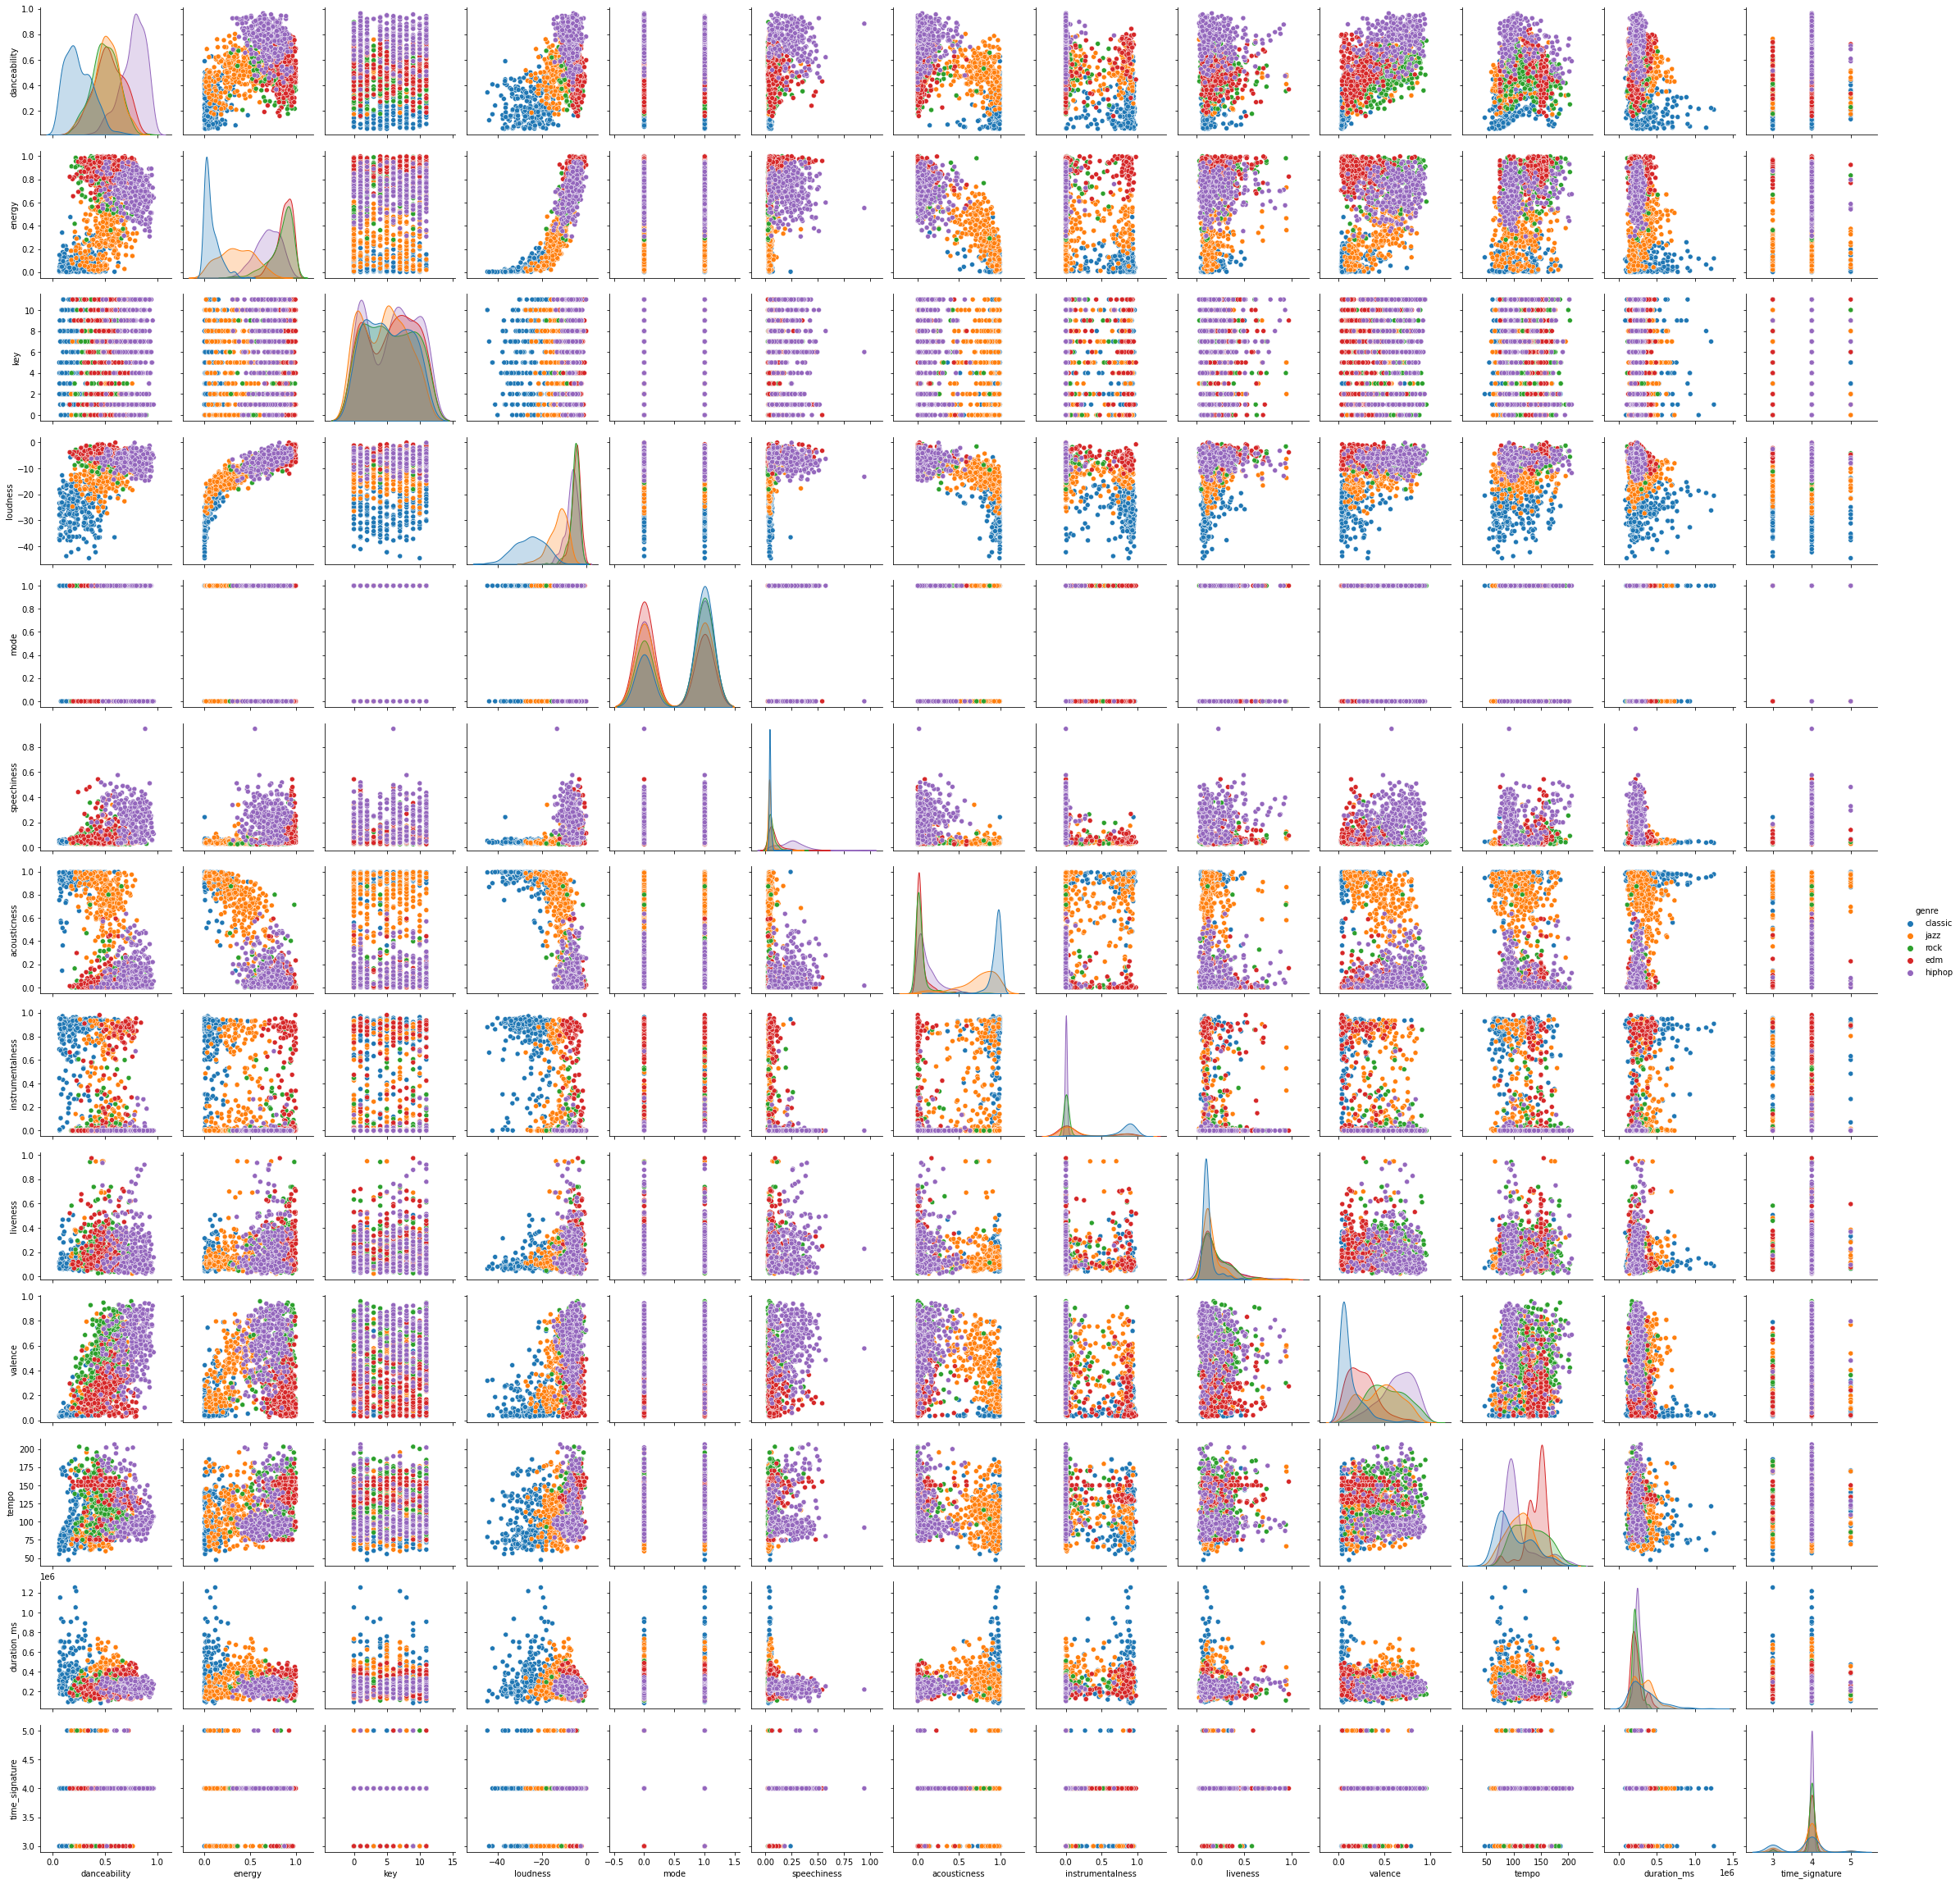

In [29]:
sns.pairplot(data=raw_data, hue="genre")

## Preprocessing

### Train test split

In [8]:
categorical_features = {'key', 'mode', 'time_signature'}
numeric_features = set(raw_data.columns) - categorical_features - {"genre"}

numeric_features = list(numeric_features)
categorical_features = list(categorical_features)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(raw_data.iloc[:,:13], raw_data.genre, test_size=0.33, stratify=raw_data.genre)
data = {
    "x_train": x_train,
    "x_test": x_test,
    "y_train": y_train,
    "y_test": y_test,
    "features": numeric_features + categorical_features,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "target": "genre"
}

### Remove correlated features

In [16]:
def find_correlated_features(df:pd.DataFrame, threshold:float) -> list:
    correlation_matrix = df.corr().abs()
    avg_correlation = correlation_matrix.mean(axis = 1)
    up = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
    drop = list()
        
    for row in range(len(up)-1):
        for col in range (row + 1, len(up)):
            if(correlation_matrix.iloc[row, col] >= threshold):
                if(avg_correlation.iloc[row] > avg_correlation.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop = list(set(drop)) 
    dropcols_names = list(df.columns[[item for item in drop]])
    
    return dropcols_names

Drop these correlated features: ['energy']


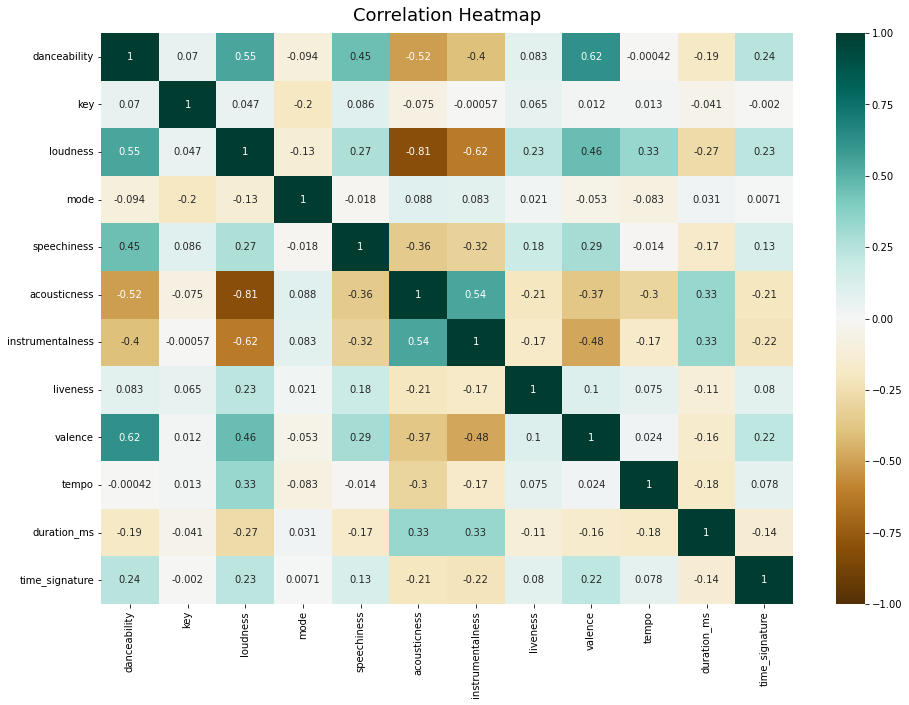

In [17]:
correlated_features = find_correlated_features(data["x_train"], 0.9)

print(f'Drop these correlated features: {correlated_features}')

data["x_train"].drop(correlated_features, axis=1, inplace=True)
[data["features"].remove(f) for f in correlated_features]
for feature in correlated_features:
    if feature in data["categorical_features"]:
        data["categorical_features"].remove(feature)
    if feature in data["numeric_features"]:
        data["numeric_features"].remove(feature)

fig = plt.figure()
heatmap = sns.heatmap(data["x_train"].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

### Normalization

In [19]:
scaler = StandardScaler()
data["x_train"][data["numeric_features"]] = scaler.fit_transform(data["x_train"][data["numeric_features"]])
data["x_train"].describe()

,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1.002000e+03,1002.000000,1.002000e+03,1002.000000,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1002.000000
mean,1.701899e-16,5.332335,-2.216014e-17,0.546906,1.063687e-16,-2.127373e-17,1.772811e-18,-6.382120e-17,-4.254747e-17,-3.722904e-17,1.648714e-16,3.932136
std,1.000499e+00,3.538899,1.000499e+00,0.498044,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,0.336559
min,-2.182170e+00,0.000000,-3.954340e+00,0.000000,-7.339732e-01,-8.908857e-01,-6.647477e-01,-1.064726e+00,-1.449404e+00,-2.301980e+00,-1.513921e+00,3.000000
25%,-6.725801e-01,2.000000,-3.845900e-01,0.000000,-5.774943e-01,-8.661475e-01,-6.647477e-01,-6.068384e-01,-9.090934e-01,-7.853297e-01,-6.258548e-01,4.000000
50%,-9.260765e-03,5.000000,3.976347e-01,1.000000,-4.630691e-01,-6.169379e-01,-6.619833e-01,-4.142007e-01,-4.784094e-02,-5.407066e-02,-2.743278e-01,4.000000
75%,7.115303e-01,8.000000,6.964464e-01,1.000000,7.531622e-02,1.169948e+00,1.062374e+00,3.450769e-01,8.095494e-01,8.430032e-01,2.913389e-01,4.000000
max,2.095641e+00,11.000000,1.240341e+00,1.000000,8.253785e+00,1.578397e+00,1.994030e+00,5.225673e+00,2.145843e+00,2.798543e+00,7.640441e+00,5.000000


### Remove outliers

## Model Selection

### PCA

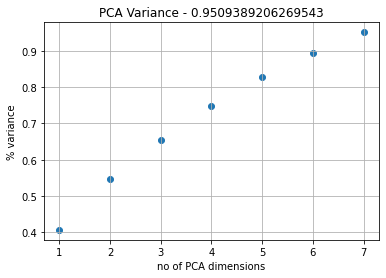

In [21]:
pca_variance_threshold = .9
pca = PCA(pca_variance_threshold)
pca.fit(data["x_train"][data["numeric_features"]])

plt.scatter(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.title(f"PCA Variance - {np.sum(pca.explained_variance_ratio_)}")
plt.xlabel("no of PCA dimensions") 
plt.ylabel("% variance")
plt.show()

In [23]:
test_pca_transform = data["x_train"].copy()

pca_components = pca.transform(test_pca_transform[data["numeric_features"]])
cols = [f"PC{x}" for x in range(1, len(pca.explained_variance_ratio_)+1)]
test_pca_transform_new = pd.DataFrame(pca_components, columns=cols, index=data["x_train"].index)
test_pca_transform = pd.concat([test_pca_transform_new, test_pca_transform[data["categorical_features"]]], axis=1)
test_pca_transform

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,key,mode,time_signature
475,1.834581,-0.079997,0.021966,-1.312623,-0.671409,-0.589302,-0.945286,7,0,4
634,-0.934837,-1.353015,-1.356289,-0.231232,0.012231,-0.385740,-0.135404,1,1,4
899,-0.541337,-1.334557,-0.899858,-0.393042,0.450780,-0.263778,0.542742,5,0,4
791,-1.479385,0.336662,0.458962,0.665916,-1.520235,-0.295254,0.159858,0,1,4
216,3.200609,0.386876,0.265294,0.316635,-0.157489,-0.909285,-1.575730,4,0,4
...,...,...,...,...,...,...,...,...,...,...
254,3.295367,-0.945651,-0.108881,1.142864,1.039112,0.453344,-0.143347,8,1,4
1267,-2.393216,1.812394,-0.610593,-0.949824,0.529665,-0.029593,-0.006126,7,0,4
829,-0.841238,-1.842664,0.716262,0.866372,-0.571682,-0.073636,-0.546236,0,1,4
1027,-1.008608,-1.943073,0.966615,0.554406,0.593591,-0.736953,-0.118138,7,0,4


### Feature Selection forward

In [24]:
for i in range(1, len(data["features"])):
    svc = SVC(C=10)
    sfs_forward = SequentialFeatureSelector(
        svc, n_features_to_select=i, direction="forward"
    ).fit(data["x_train"], data["y_train"])

    feature_names = list(sfs_forward.get_feature_names_out())
    svc.fit(data["x_train"][feature_names], data["y_train"])
    print(f'No. of features: {len(feature_names)}, Features: {feature_names}, Score: {svc.score(data["x_test"][feature_names], data["y_test"])}')

No. of features: 1, Features: ['acousticness'], Score: 0.35020242914979755
No. of features: 2, Features: ['danceability', 'acousticness'], Score: 0.3360323886639676
No. of features: 3, Features: ['danceability', 'acousticness', 'valence'], Score: 0.32388663967611336
No. of features: 4, Features: ['danceability', 'acousticness', 'valence', 'tempo'], Score: 0.1882591093117409
No. of features: 5, Features: ['danceability', 'loudness', 'acousticness', 'valence', 'tempo'], Score: 0.1882591093117409
No. of features: 6, Features: ['danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo'], Score: 0.1882591093117409
No. of features: 7, Features: ['danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'], Score: 0.2165991902834008
No. of features: 8, Features: ['danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms'], Score: 0.1882591093117409
No. of features: 9, Features: 

KeyboardInterrupt: 